# Comparative Analysis of Bounding Boxes for Each Fruit Class

The objective is to visualize and compare, for an example of each fruit class, the two methods of generating a bounding box:

1.  **Bounding Box from Manual Annotation (XML):** Loads the exact coordinates that were manually annotated (the location Ground Truth).
2.  **Bounding Box from Segmentation Mask:** Loads the segmentation mask and algorithmically calculates the smallest rectangle that encloses the object.

This comparison allows us to visually assess the accuracy of the bounding box generated from the mask across our entire dataset.

In [1]:
# Import Libraries and Configure Paths

import cv2
import numpy as np
import os
import glob
from collections import defaultdict 
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from IPython.display import display

# Configure Matplotlib to display plots inline within the notebook
%matplotlib inline

# --- PROJECT PATHS AND DATA CONFIGURATION ---
ORIGINAL_IMAGES_FOLDER = 'original_dataset'
XML_ANNOTATIONS_PATH = 'bbox_annotations.xml'
MASKS_FOLDER = 'ground_truth'

# Mapping from Class ID to fruit name
CLASS_ID_MAPPING = {
    '0': "acerola", '1': "lemon", '2': "cherry_tomato", '3': "khaki",
    '4': "banana", '5': "lime", '6': "clove_lemon", '7': "avocado",
    '8': "bergamot", '9': "pear"
}

### Helper Functions

Here we define the functions that will process the files. One function reads the data from the XML file, and the other calculates the bounding box from a mask image.

In [2]:
# Definition of Helper Functions

def load_annotation_from_xml(xml_path, image_name):
    """Reads a CVAT XML file and finds the annotation for a specific image."""
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        for image_tag in root.findall(f".//image[@name='{image_name}']"):
            box_tag = image_tag.find('box')
            if box_tag is not None:
                label = box_tag.get('label')
                xtl = int(float(box_tag.get('xtl')))
                ytl = int(float(box_tag.get('ytl')))
                xbr = int(float(box_tag.get('xbr')))
                ybr = int(float(box_tag.get('ybr')))
                # Returns (label, (x, y, w, h))
                return label, (xtl, ytl, xbr - xtl, ybr - ytl)
    except Exception as e:
        print(f"Error reading XML: {e}")
    return None, None

def generate_bbox_from_mask(mask):
    """Calculates the Bounding Box from a segmentation mask."""
    if mask is None: return None
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        largest_contour = max(contours, key=cv2.contourArea)
        # Returns (x, y, w, h)
        return cv2.boundingRect(largest_contour)
    return None

### Processing and Visualization of an Example
Now, let's choose an example image and apply the two methods. The result of each method will be drawn on a copy of the original image so we can compare them visually.

- The green box represents the manual annotation from the XML file.

- The blue box represents the annotation calculated from the segmentation mask.

Found 10 examples for visualization (one per class).

--- Processing: 0-02-V1-W.png ---


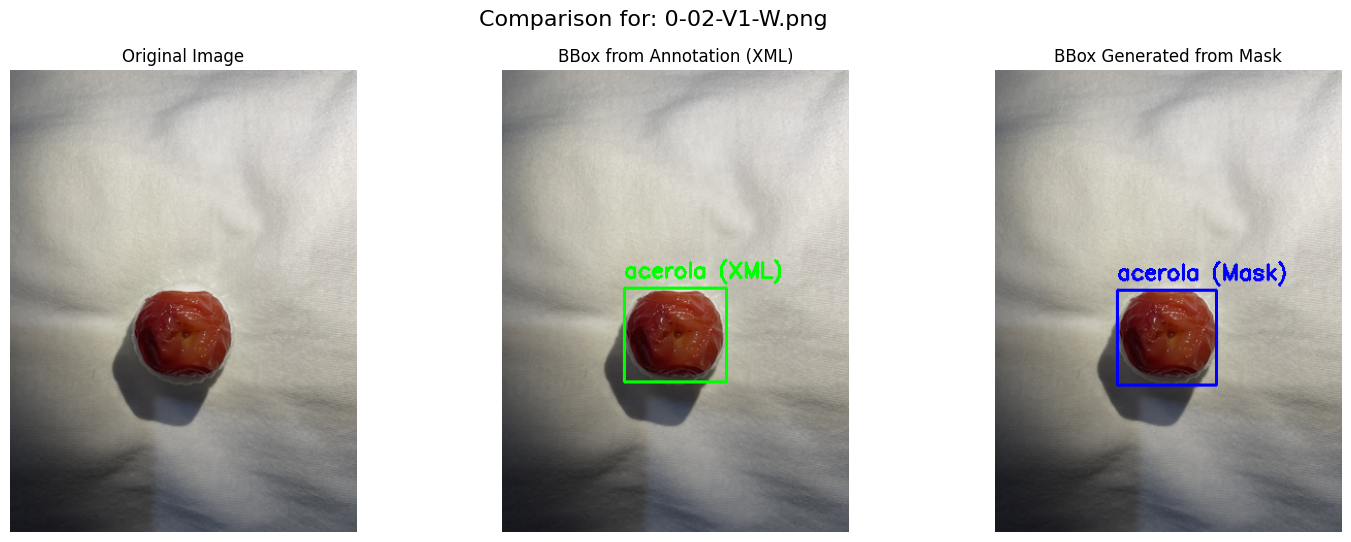

--- Processing: 1-01-V1-W.png ---


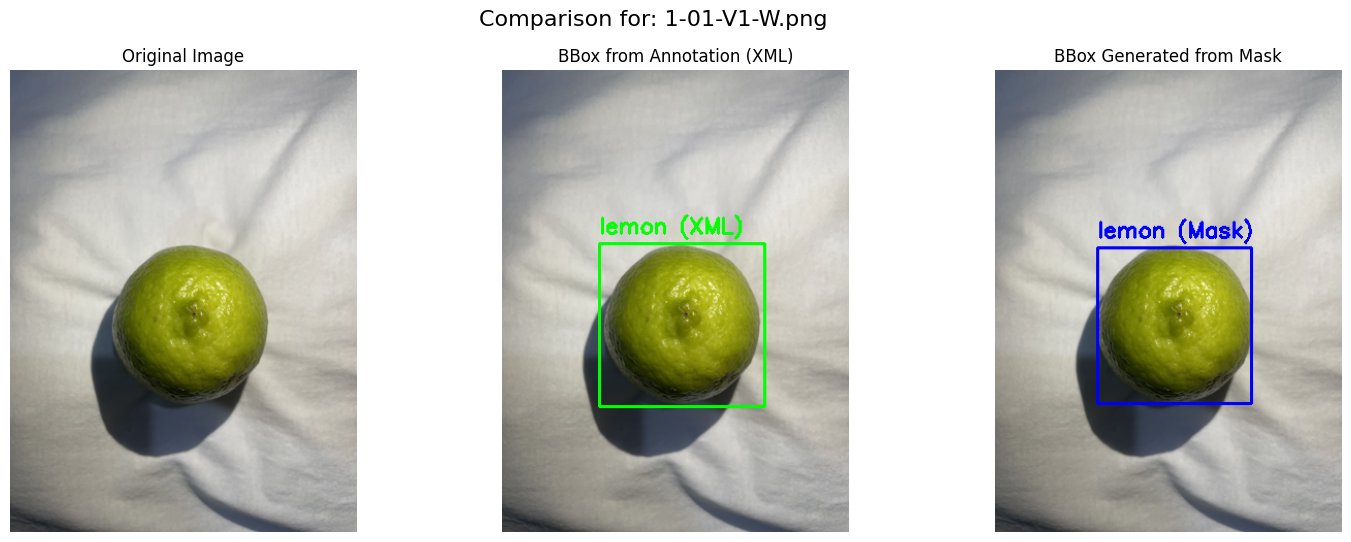

--- Processing: 2-05-V1-W.png ---


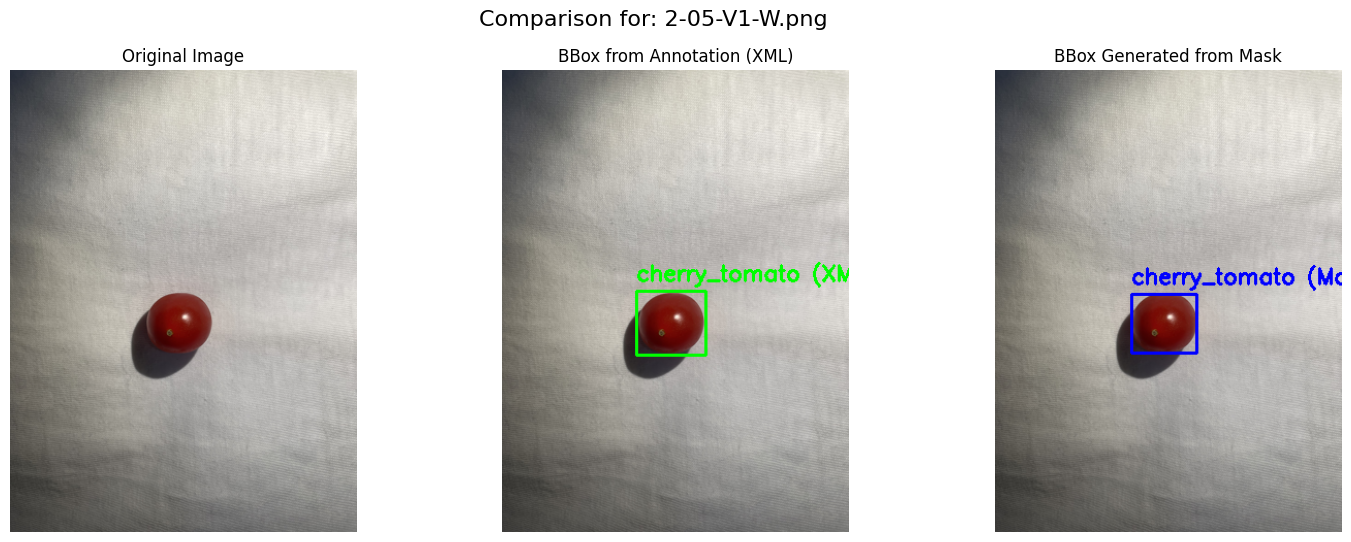

--- Processing: 3-05-V1-B.png ---


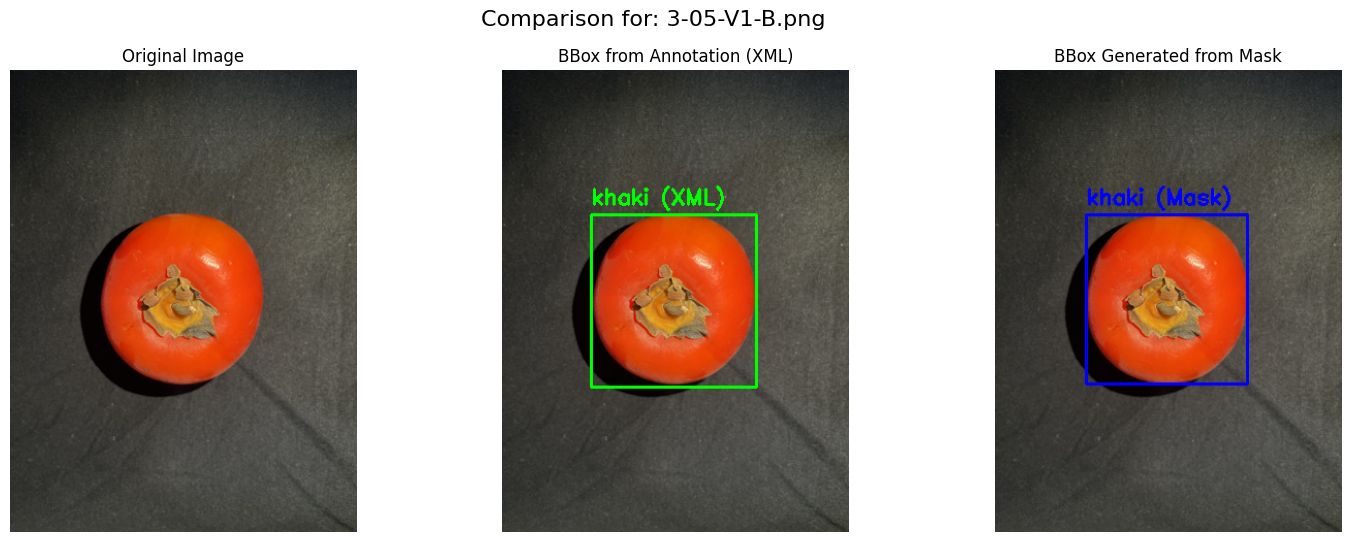

--- Processing: 4-02-V1-W.png ---


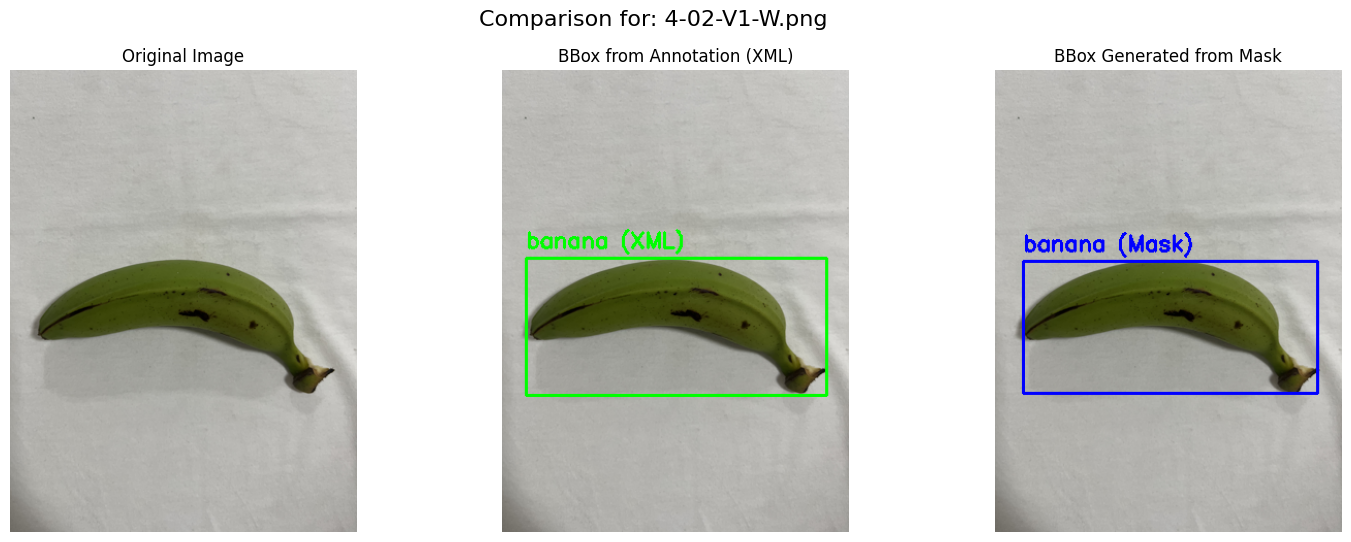

--- Processing: 5-05-V1-W.png ---


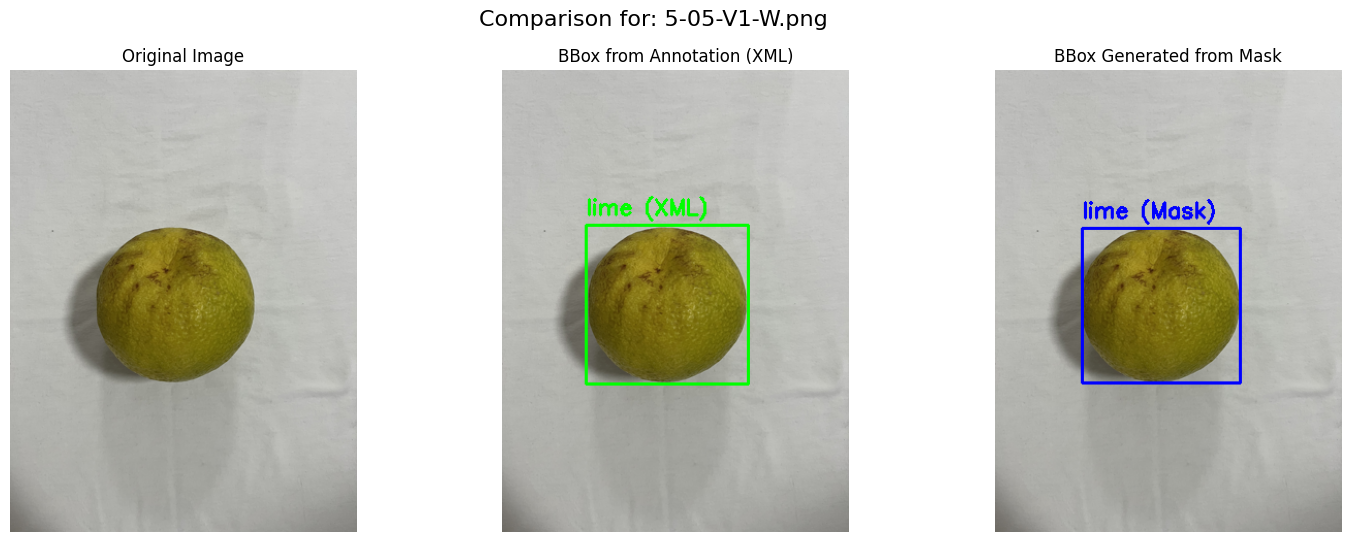

--- Processing: 6-01-V2-W.png ---


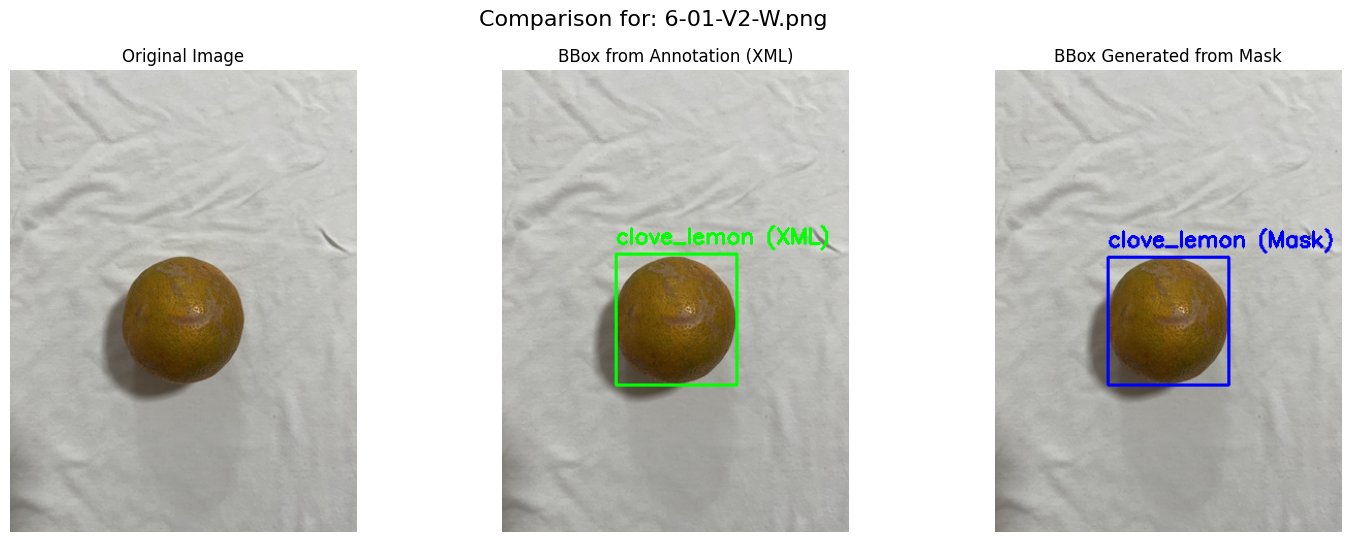

--- Processing: 7-04-V1-W.png ---


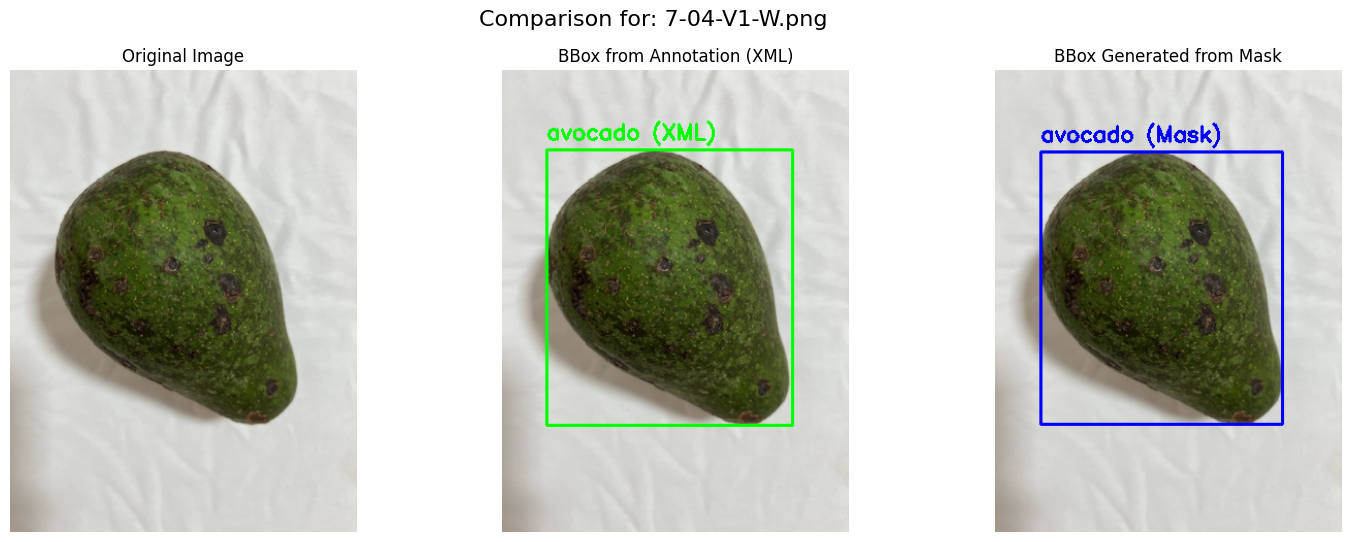

--- Processing: 8-02-V2-B.png ---


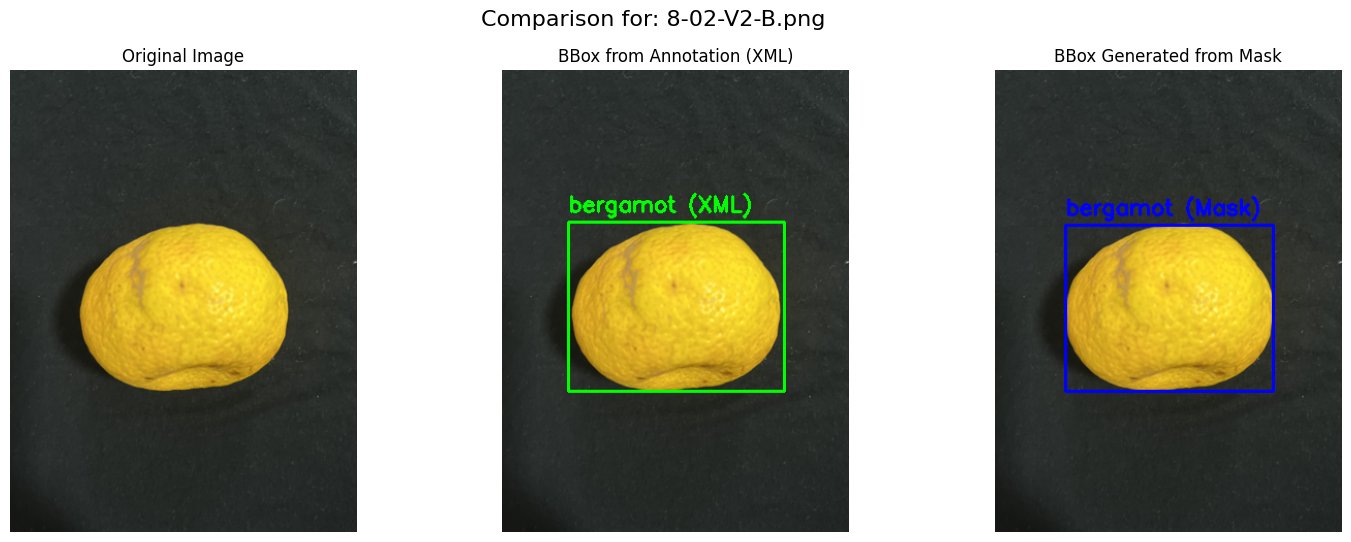

--- Processing: 9-03-V1-B.png ---


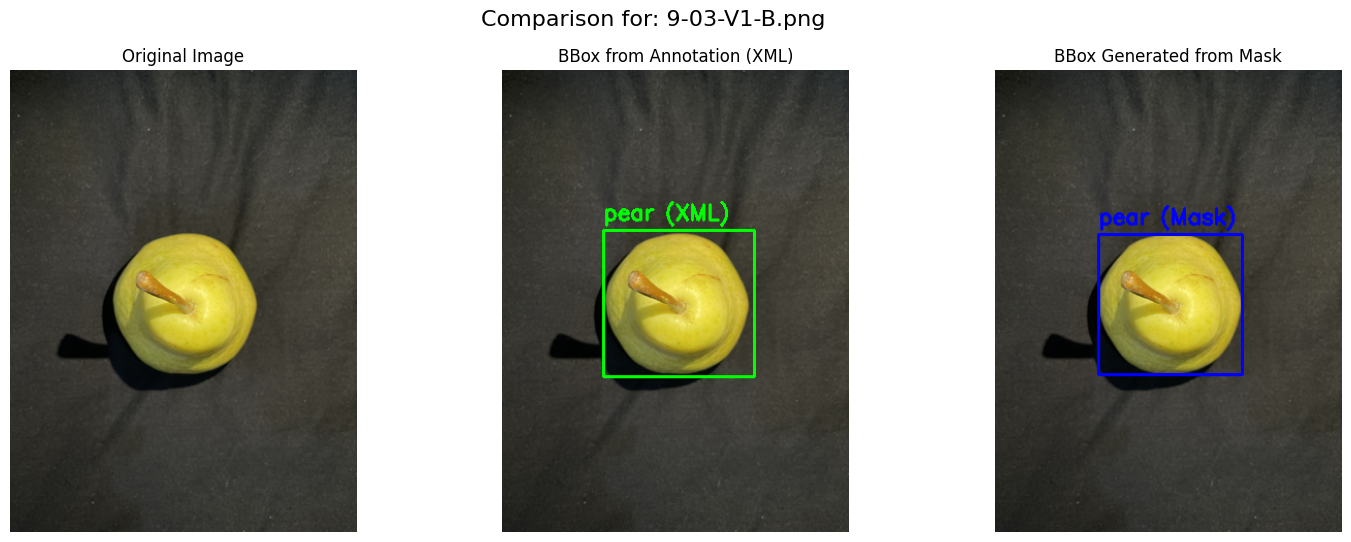

In [3]:
# Main Batch Processing and Visualization Logic

# 1. Group all images by class
images_by_class = defaultdict(list)
all_files = glob.glob(os.path.join(ORIGINAL_IMAGES_FOLDER, '*.png'))
for img_path in all_files:
    class_id = os.path.basename(img_path).split('-')[0]
    if class_id in CLASS_ID_MAPPING:
        images_by_class[class_id].append(img_path)

# 2. Create a list with one example from each class
example_list = []
# We use sorted to maintain a consistent order
for class_id in sorted(CLASS_ID_MAPPING.keys()):
    if images_by_class[class_id]:
        example_list.append(images_by_class[class_id][0])

print(f"Found {len(example_list)} examples for visualization (one per class).\n")
      
# 3. Main loop to process and display each example
for example_image_path in example_list:
    example_filename = os.path.basename(example_image_path)
    print(f"--- Processing: {example_filename} ---")
    
    # Build the full paths for the example files
    mask_path = os.path.join(MASKS_FOLDER, example_filename)
    
    # Load the data
    original_image = cv2.imread(example_image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if original_image is None:
        print(f"  -> Error loading original image. Skipping.")
        continue

    # Process 1: Generate the image with the BBox from the XML
    image_with_xml_bbox = original_image.copy()
    label_from_xml, bbox_from_xml = load_annotation_from_xml(XML_ANNOTATIONS_PATH, example_filename)
    if bbox_from_xml:
        (x, y, w, h) = bbox_from_xml
        # Draw the XML box (Ground Truth) in GREEN
        cv2.rectangle(image_with_xml_bbox, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(image_with_xml_bbox, f"{label_from_xml} (XML)", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    # Process 2: Generate the image with the BBox from the Mask
    image_with_mask_bbox = original_image.copy()
    bbox_from_mask = generate_bbox_from_mask(mask)
    if bbox_from_mask:
        (x, y, w, h) = bbox_from_mask
        # Draw the Mask-generated box in BLUE
        cv2.rectangle(image_with_mask_bbox, (x, y), (x + w, y + h), (255, 0, 0), 2)
        # Get the label from the filename
        class_id = example_filename.split('-')[0]
        label_from_mask = CLASS_ID_MAPPING.get(class_id, "Unknown")
        cv2.putText(image_with_mask_bbox, f"{label_from_mask} (Mask)", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

    # Convert from BGR (OpenCV) to RGB (Matplotlib) for correct display
    image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    image_with_xml_bbox_rgb = cv2.cvtColor(image_with_xml_bbox, cv2.COLOR_BGR2RGB)
    image_with_mask_bbox_rgb = cv2.cvtColor(image_with_mask_bbox, cv2.COLOR_BGR2RGB)

    # Create the figure and axes for the plot
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f"Comparison for: {example_filename}", fontsize=16)
    
    ax[0].imshow(image_rgb)
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    ax[1].imshow(image_with_xml_bbox_rgb)
    ax[1].set_title("BBox from Annotation (XML)")
    ax[1].axis('off')

    ax[2].imshow(image_with_mask_bbox_rgb)
    ax[2].set_title("BBox Generated from Mask")
    ax[2].axis('off')
    
    display(fig)
    plt.close(fig)
